# 1. Import Required Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


## 2. Dataset Loading


In [ ]:
df = pd.read_csv('/content/bank.csv')

print(df.head())
print(df.info())
print(df['deposit'].value_counts())

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 

# Missing Values Check

In [ ]:
print(df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


# Encode Target

In [ ]:
y = LabelEncoder().fit_transform(df['deposit'])

# One-Hot Encode Categorical Features

In [ ]:
categorical_cols = [
    'job','marital','education','default','housing',
    'loan','contact','month','poutcome'
]

X = pd.get_dummies(
    df.drop('deposit', axis=1),
    columns=categorical_cols,
    drop_first=True
)

# Train / Validation / Test Split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.222,
    random_state=42, stratify=y_train_val)

# Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Class Distribution Before SMOTE

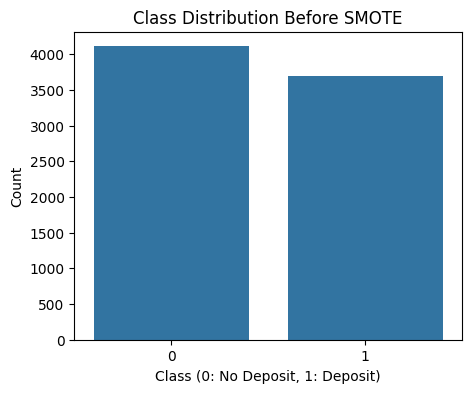

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class (0: No Deposit, 1: Deposit)")
plt.ylabel("Count")
plt.show()

# Apply SMOTE (Training Only)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Class Distribution After SMOTE

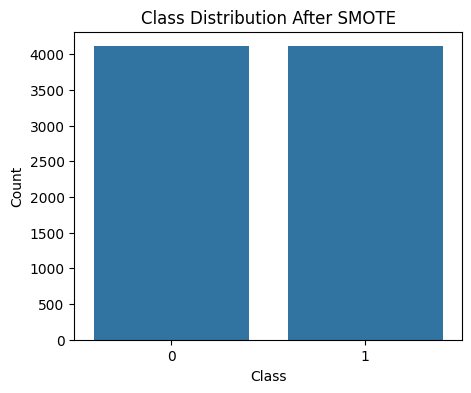

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Phase 2: Neural Network Design (WP1 + WP3)

In [ ]:
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),

        Dense(256, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=l2(5e-4)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=l2(5e-4)),
        BatchNormalization(),
        Dropout(0.35),

        Dense(64, activation='relu',
              kernel_initializer='he_normal'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    return model

## Compile Model

In [ ]:
model = build_model(X_train_res.shape[1])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,761 (210.00 KB)

 Trainable params: 52,993 (207.00 KB)

 Non-trainable params: 768 (3.00 KB)

# Phase 3: Model Training & Evaluation (WP1 + WP3)

## Callbacks

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    min_lr=1e-6
)

## Train Model

In [ ]:
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/150
257/257 - 7s - 26ms/step - accuracy: 0.6621 - loss: 1.0573 - val_accuracy: 0.8072 - val_loss: 0.8041 - learning_rate: 5.0000e-04
Epoch 2/150
257/257 - 1s - 4ms/step - accuracy: 0.7473 - loss: 0.9055 - val_accuracy: 0.8179 - val_loss: 0.7641 - learning_rate: 5.0000e-04
Epoch 3/150
257/257 - 1s - 5ms/step - accuracy: 0.7755 - loss: 0.8401 - val_accuracy: 0.8323 - val_loss: 0.7321 - learning_rate: 5.0000e-04
Epoch 4/150
257/257 - 1s - 3ms/step - accuracy: 0.7898 - loss: 0.8042 - val_accuracy: 0.8399 - val_loss: 0.7096 - learning_rate: 5.0000e-04
Epoch 5/150
257/257 - 1s - 3ms/step - accuracy: 0.7991 - loss: 0.7768 - val_accuracy: 0.8444 - val_loss: 0.6894 - learning_rate: 5.0000e-04
Epoch 6/150
257/257 - 1s - 3ms/step - accuracy: 0.8071 - loss: 0.7529 - val_accuracy: 0.8453 - val_loss: 0.6766 - learning_rate: 5.0000e-04
Epoch 7/150
257/257 - 1s - 3ms/step - accuracy: 0.8136 - loss: 0.7273 - val_accuracy: 0.8462 - val_loss: 0.6601 - learning_rate: 5.0000e-04
Epoch 8/150
257/257

## Plot Accuracy & Loss

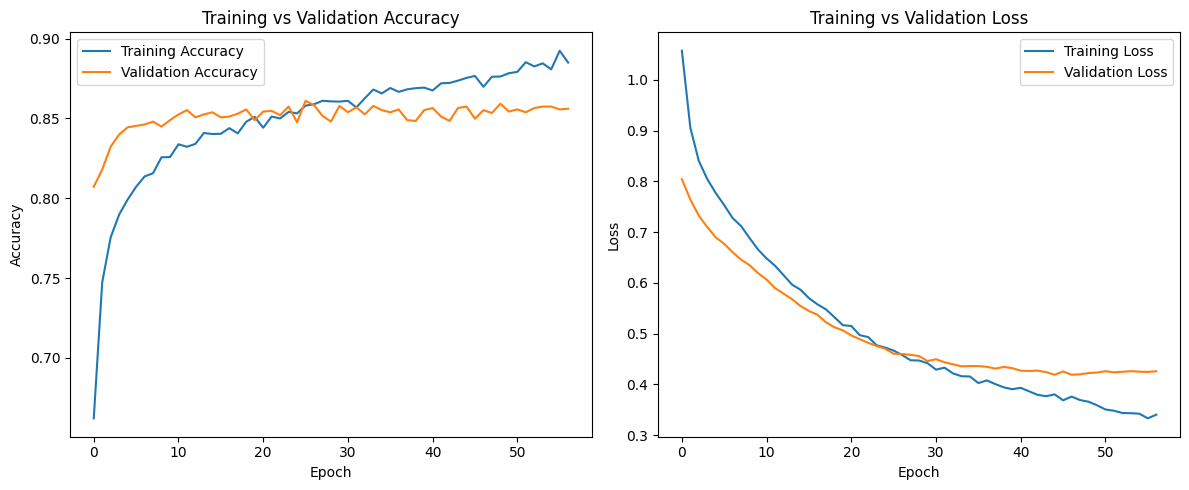

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Predict Probabilities



In [ ]:
y_pred_prob = model.predict(X_test).flatten()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


## Optimize Threshold Using F1-Score

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

best_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", best_threshold)

y_pred = (y_pred_prob >= best_threshold).astype(int)

Optimal Threshold: 0.39861068


## Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       588
           1       0.82      0.92      0.87       529

    accuracy                           0.87      1117
   macro avg       0.87      0.87      0.87      1117
weighted avg       0.88      0.87      0.87      1117



## Confusion Matrix

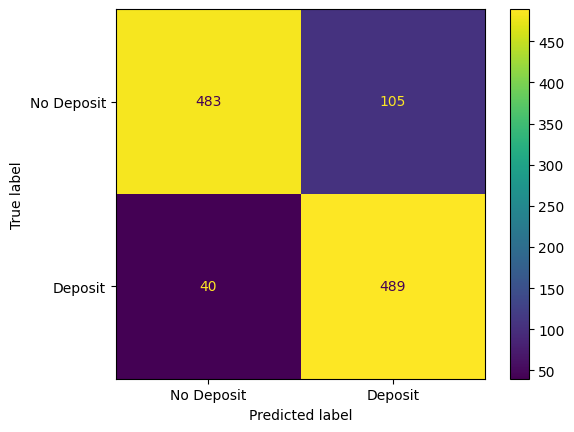

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['No Deposit', 'Deposit']
)
plt.show()